In [1]:
import jVMC
import matplotlib.pyplot as plt
import numpy as np 
from jVMC.operator import *
import jax.random as jrnd
import jax.numpy as jnd
from tqdm import tqdm
from jVMC import operator as op
import optax

In [2]:

def adam_update(psi,psiSampler,H,stateAdam,optAdam):
    psi_s, psi_logPsi, psi_p = psiSampler.sample()

    Eloc = H.get_O_loc(psi_s, psi, psi_logPsi)
    Eso = jVMC.util.SampledObs(Eloc, psi_p)
    Emean = Eso.mean()[0]
    Evar = Eso.var()[0]
    Opsi = psi.gradients(psi_s)
    grads = jVMC.util.SampledObs(Opsi, psi_p)
    Egrad = 2.*grads.covar(Eso)
    grad = jnp.real(Egrad)
    
    psi_params = psi.get_parameters()
    
    upAdam, stateAdam = optAdam.update(
        grad.reshape(psi_params.shape), stateAdam, psi_params  # type: ignore
    )
    
    params = optax.apply_updates(psi_params, upAdam)  # type: ignore
    
    psi.set_parameters(params)
    return Emean.real,Evar,stateAdam


In [3]:
L = 7
T = 0.01
E_c = 0.40
E_J = np.array([12.500,12.00]*(L//2) + ([12.500] if ((L%2)==1) else [] ))
lDim = 7

In [4]:
#transmon on a chain
hamiltonian1D = jVMC.operator.BranchFreeOperator(lDim=lDim)
for l in range(L):    
    hamiltonian1D.add(jVMC.operator.scal_opstr(-E_J[l]/2., (jVMC.operator.E(l,lDim),)))
    hamiltonian1D.add(jVMC.operator.scal_opstr(-E_J[l]/2., (jVMC.operator.Ed(l,lDim),)))
    #hamiltonian1D.add(jVMC.operator.scal_opstr(-E_J[l], (jVMC.operator.create(l,lDim),jVMC.operator.Id(l,lDim))))
    #hamiltonian1D.add(jVMC.operator.scal_opstr(-E_J[l], (jVMC.operator.destroy(l,lDim),jVMC.operator.Id(l,lDim))))
    
    hamiltonian1D.add(jVMC.operator.scal_opstr(4*E_c, (jVMC.operator.number(l,lDim ),jVMC.operator.number(l,lDim )) ))
    if (l<(L-1)):
        hamiltonian1D.add(jVMC.operator.scal_opstr(T, (jVMC.operator.number(l,lDim ),jVMC.operator.number(l+1,lDim )) ))
hamiltonian1D.compile();

In [5]:
depth_RWKV = 4
emb_RWKV =8
hidden_size=32
num_heads = 8
net_RWKV = jVMC.nets.bosons.RWKV(L,Q=None,M=None,LocalHilDim=lDim,num_layers=depth_RWKV,embedding_size=emb_RWKV)

net_RWKV_new = jVMC.nets.RWKV.CpxRWKV(L,LocalHilDim=lDim,hidden_size=hidden_size,num_heads=num_heads,embedding_size=emb_RWKV,num_layers=depth_RWKV)


net_RWKV = net_RWKV_new

In [6]:
seed = 25261
psi_RWKV = jVMC.vqs.NQS(net_RWKV,seed=seed)

homFock = jnp.ones((1,1,L),dtype=int)

psi_RWKV(homFock)

Array([[-7.76584939+4.56771189j]], dtype=complex128)

In [7]:
key = jrnd.PRNGKey(21)
sampler = jVMC.sampler.MCSampler(psi_RWKV,(L,),key)


energy: -45.1103+-8.9548: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [08:16<00:00,  1.01it/s]


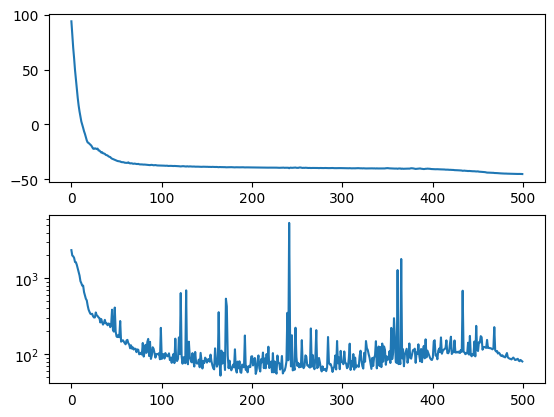

In [8]:
#adam 
lr_ADAM = 1e-3
optAdam = optax.inject_hyperparams(optax.adamax)(learning_rate=lr_ADAM)

stateAdam = optAdam.init(psi_RWKV.get_parameters()) 
training_steps= 500
resTrainingADAM = np.zeros((training_steps,2))
numS = 2**15
sampler.set_number_of_samples(numS)
pbar = tqdm(range(training_steps))
for n,p in enumerate(pbar):
    
    Emean,Evar,stateAdam = adam_update(psi_RWKV,sampler,hamiltonian1D,stateAdam,optAdam)

    resTrainingADAM[n] = [Emean , Evar ]
    
    pbar.set_description(f"energy: {resTrainingADAM[n][0]:.4f}+-{np.sqrt(resTrainingADAM[n][1]):.4f}")

fig,ax = plt.subplots(2)
ax[0].plot(resTrainingADAM[:,0])
ax[1].semilogy(resTrainingADAM[:,1])

energy: -32.3951+-18.5646: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:27<00:00,  1.13s/it]


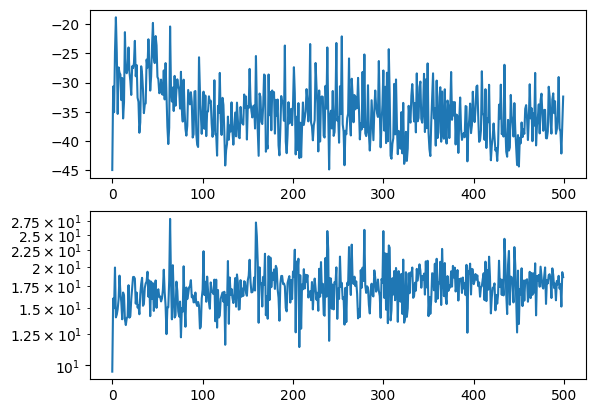

In [9]:
training_steps= 500
resTrainingSR = np.zeros((training_steps,2))
lr_SR = 1e-1
minSR_equation = jVMC.util.MinSR(sampler, makeReal='real',diagonalShift=1e-2,diagonalMulti=1e-2)

stepperSR = jVMC.util.stepper.Euler(timeStep=lr_SR)  
    
numS = 2**10
pbar = tqdm(range(training_steps))
for n,p in enumerate(pbar):
    
    dpOld = psi_RWKV.get_parameters()        
    
    #print(dpOld)
    dp, _ = stepperSR.step(0, minSR_equation, dpOld, hamiltonian=hamiltonian1D, psi=psi_RWKV, numSamples=numS)
    psi_RWKV.set_parameters(jnp.real(dp))
    resTrainingSR[n] = [jnp.real(minSR_equation.ElocMean0) , minSR_equation.ElocVar0 ]

    #psi_s, psi_logPsi, psi_p = sampler.sample()
    #Eloc = hamiltonian1D.get_O_loc(psi_s, psi_RWKV, psi_logPsi)
    #Eso = jVMC.util.SampledObs(Eloc, psi_p)
    #Emean = Eso.mean()[0]
    #print(Emean,minSR_equation.ElocMean0)
    pbar.set_description(f"energy: {resTrainingSR[n][0]:.4f}+-{np.sqrt(resTrainingSR[n][1]):.4f}")
fig,ax = plt.subplots(2)
ax[0].plot(resTrainingSR[:,0])
ax[1].semilogy(np.sqrt(resTrainingSR[:,1]))

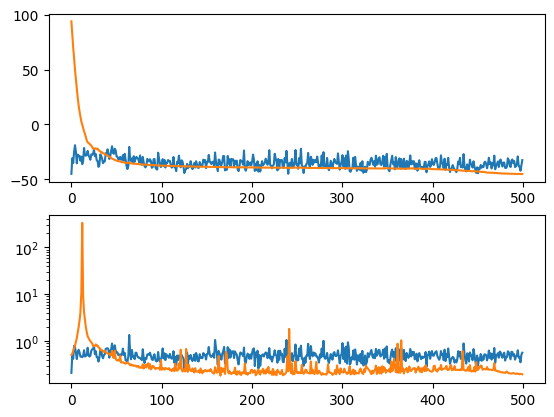

In [10]:
fig,ax = plt.subplots(2)
ax[0].plot(resTrainingSR[:,0])
ax[0].plot(resTrainingADAM[:,0])

ax[1].semilogy(np.sqrt(resTrainingSR[:,1])/np.abs(resTrainingSR[:,0]))
ax[1].semilogy(np.sqrt(resTrainingADAM[:,1])/np.abs(resTrainingADAM[:,0]))


In [11]:
sam,plog,_ = sampler.sample(numSamples=200)

In [12]:
jnp.max(plog)
sam

Array([[[0, 2, 0, ..., 1, 0, 1],
        [0, 0, 1, ..., 0, 1, 0],
        [1, 1, 0, ..., 1, 2, 2],
        ...,
        [0, 1, 1, ..., 1, 3, 0],
        [1, 1, 2, ..., 1, 1, 0],
        [1, 1, 0, ..., 0, 1, 1]]], dtype=int64)

In [13]:
sam[0][:20],jnp.sum(sam[0][:20],axis=1)

(Array([[0, 2, 0, 0, 1, 0, 1],
        [0, 0, 1, 2, 0, 1, 0],
        [1, 1, 0, 1, 1, 2, 2],
        [0, 1, 0, 1, 1, 2, 2],
        [1, 1, 0, 0, 2, 1, 0],
        [0, 1, 2, 2, 1, 2, 2],
        [0, 0, 1, 1, 1, 0, 1],
        [1, 0, 2, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0],
        [1, 0, 1, 1, 0, 1, 2],
        [2, 1, 1, 1, 1, 0, 2],
        [1, 1, 1, 1, 1, 1, 0],
        [1, 0, 3, 0, 0, 0, 0],
        [1, 1, 2, 0, 1, 3, 2],
        [1, 1, 0, 1, 0, 1, 1],
        [1, 1, 1, 0, 2, 2, 0],
        [1, 0, 0, 1, 1, 0, 3],
        [0, 1, 1, 2, 1, 0, 1],
        [0, 2, 1, 1, 2, 1, 2],
        [1, 1, 0, 1, 0, 0, 1]], dtype=int64),
 Array([ 4,  4,  8,  7,  5, 10,  4,  4,  2,  6,  8,  6,  4, 10,  5,  7,  6,
         6,  9,  4], dtype=int64))

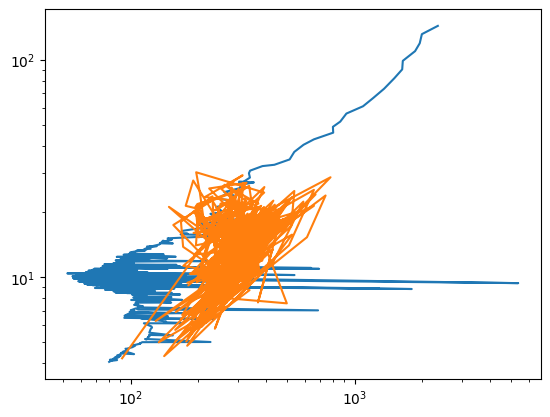

In [14]:
plt.loglog(resTrainingADAM[:,1],np.abs(-49.17507554699675-resTrainingADAM[:,0]))
plt.loglog(resTrainingSR[:,1],np.abs(-49.17507554699675-resTrainingSR[:,0]))
